# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import random
import torch
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent, ReplayBuffer

from unityagents import UnityEnvironment
import numpy as np


# Load Reacher env with 20 agents
env = UnityEnvironment(file_name='Reacher')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Instantiate DDPG Agent

In [4]:
random_seed = 7
train_mode = True

agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [6]:
def ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                            # initialize the score (for each agent)
        agent.reset()
        
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # send actions to the agent
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if t%learn_every == 0:
                for _ in range(num_learn):
                    agent.start_learn()
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode {}\tTotal Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tDuration: {:.2f}'
              .format(i_episode, total_average_score, mean_score, min_score, max_score, duration))

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode, total_average_score))  
            
        if total_average_score >= goal_score and i_episode >= 100:
            print('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return total_scores

scores = ddpg()



/home/workspace/ddpg_agent.py:105: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 1	Total Average Score: 0.46	Mean: 0.46	Min: 0.00	Max: 1.28	Duration: 21.17
Episode 2	Total Average Score: 0.62	Mean: 0.78	Min: 0.08	Max: 1.82	Duration: 22.41
Episode 3	Total Average Score: 0.63	Mean: 0.65	Min: 0.09	Max: 1.77	Duration: 23.10
Episode 4	Total Average Score: 0.63	Mean: 0.62	Min: 0.05	Max: 1.29	Duration: 22.99
Episode 5	Total Average Score: 0.61	Mean: 0.55	Min: 0.06	Max: 1.38	Duration: 23.89
Episode 6	Total Average Score: 0.61	Mean: 0.61	Min: 0.00	Max: 1.48	Duration: 24.57
Episode 7	Total Average Score: 0.60	Mean: 0.56	Min: 0.00	Max: 1.43	Duration: 24.56
Episode 8	Total Average Score: 0.63	Mean: 0.86	Min: 0.05	Max: 1.68	Duration: 24.69
Episode 9	Total Average Score: 0.68	Mean: 1.04	Min: 0.02	Max: 2.59	Duration: 24.93
Episode 10	Total Average Score: 0.71	Mean: 1.04	Min: 0.00	Max: 2.08	Duration: 25.67
Episode 10	Total Average Score: 0.71
Episode 11	Total Average Score: 0.77	Mean: 1.27	Min: 0.19	Max: 2.67	Duration: 26.31
Episode 12	Total Average Score: 0.81	Mean: 1.35	

Episode 92	Total Average Score: 28.60	Mean: 38.22	Min: 36.25	Max: 39.37	Duration: 65.05
Episode 93	Total Average Score: 28.70	Mean: 37.96	Min: 36.15	Max: 38.92	Duration: 64.36
Episode 94	Total Average Score: 28.80	Mean: 38.01	Min: 34.28	Max: 39.17	Duration: 64.26
Episode 95	Total Average Score: 28.90	Mean: 38.85	Min: 37.41	Max: 39.46	Duration: 64.02
Episode 96	Total Average Score: 28.99	Mean: 37.55	Min: 33.83	Max: 39.33	Duration: 64.13
Episode 97	Total Average Score: 29.08	Mean: 37.57	Min: 34.29	Max: 38.93	Duration: 64.68
Episode 98	Total Average Score: 29.18	Mean: 38.33	Min: 36.13	Max: 39.60	Duration: 64.62
Episode 99	Total Average Score: 29.27	Mean: 37.88	Min: 34.68	Max: 39.27	Duration: 64.87
Episode 100	Total Average Score: 29.35	Mean: 37.46	Min: 34.43	Max: 38.64	Duration: 64.81
Episode 100	Total Average Score: 29.35
Episode 101	Total Average Score: 29.73	Mean: 38.75	Min: 37.45	Max: 39.65	Duration: 63.99
Episode 102	Total Average Score: 30.10	Mean: 38.23	Min: 35.19	Max: 39.50	Durati

### 5. Plot the result

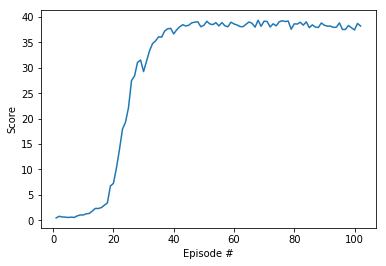

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [5]:
# Load the saved weights into Pytorch model
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

Total score: 38.21249914588407


When finished, you can close the environment.

In [6]:
env.close()